In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
import itertools
from keras.layers import LSTM

from keras.layers import Dropout

2025-05-22 15:52:23.051472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747929143.254785      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747929143.310970      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
df = pd.read_csv(
    '/kaggle/input/tempura/open-meteo-10.65N106.76E6m (1).csv',
    sep=',',
    skiprows=3,                
    parse_dates=['time'],     
    infer_datetime_format=True,
    low_memory=False,
    na_values=['nan', '?'],
    index_col='time'          
)
df =df.iloc[:,:2].last('30Y')

/tmp/ipykernel_35/3455180710.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipykernel_35/3455180710.py:11: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df =df.iloc[:,:2].last('30Y')
/tmp/ipykernel_35/3455180710.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df =df.iloc[:,:2].last('30Y')


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [13]:
import os
import wandb


os.environ["WANDB_LOG_MODEL"] = "false"
os.environ["WANDB_API_KEY"] = "05e77228f87f2442c1158e950b18e36123dd4c6c"
wandb.init(project="lstm-forecasting-final", config={
    "epochs": 20,
    "batch_size": 128,
    "n_in":24,
    "n_out":1,
    "optimizer": "adam",
    "loss_function": "mean_squared_error",
    "lstm_units": 100,
    "dropout_rate": 0.2
})

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,19
best_val_loss,0.00205
epoch,19
loss,0.00114
val_loss,0.00205


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [6]:
from wandb.integration.keras import WandbCallback
class LSTMDataPreparer:
    def __init__(self, df: pd.DataFrame, n_in: int = 3, n_out: int = 1, test_days: int = 365):
        self.df = df.copy()
        self.n_in = n_in
        self.n_out = n_out
        self.test_days = test_days
        self.n_features = df.shape[1]
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.reframed = None
        self.model = None

        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.test_y = None

    def preprocess(self):
        values = self.df.values.astype('float32')
        scaled = self.scaler.fit_transform(values)
        self.reframed = series_to_supervised(scaled, self.n_in, self.n_out)
        return self.reframed

    def create_train_test(self):
        if self.reframed is None:
            self.preprocess()

        values = self.reframed.values
        test_size = self.test_days * 24
        train = values[:-test_size, :]
        test = values[-test_size:, :]

        n_obs = self.n_in * self.n_features
        self.train_X, self.train_y = train[:, :n_obs], train[:, n_obs:]
        self.test_X, self.test_y = test[:, :n_obs], test[:, n_obs:]

        self.train_X = self.train_X.reshape((self.train_X.shape[0], self.n_in, self.n_features))
        self.test_X = self.test_X.reshape((self.test_X.shape[0], self.n_in, self.n_features))

        print("Shapes:")
        print("train_X:", self.train_X.shape)
        print("train_y:", self.train_y.shape)
        print("test_X:", self.test_X.shape)
        print("test_y:", self.test_y.shape)

    def inverse_transform_y(self, y_scaled):
        dummy = np.zeros((y_scaled.shape[0], self.n_features))
        dummy[:, :y_scaled.shape[1]] = y_scaled
        return self.scaler.inverse_transform(dummy)[:, :y_scaled.shape[1]]

    def train_model(self):
        if self.train_X is None or self.train_y is None:
            self.create_train_test()

        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(self.train_X.shape[1], self.train_X.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(self.train_y.shape[1]))
        self.model.compile(loss='mean_squared_error', optimizer='adam')

        history = self.model.fit(
            self.train_X, self.train_y,
            epochs=wandb.config.epochs,
            batch_size=wandb.config.batch_size,
            validation_data=(self.test_X, self.test_y),
            verbose=2,
            shuffle=False,
            callbacks=[WandbCallback(
                save_model=False,
                log_weights=True,
                log_evaluation=False,
                save_graph=False
            )]
        )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

    def evaluate(self):
        if self.model is None:
            raise ValueError("Model is not trained yet.")
        if self.test_X is None or self.test_y is None:
            self.create_train_test()

        y_pred = self.model.predict(self.test_X)
        y_pred_scaled = self.inverse_transform_y(y_pred)
        y_true_scaled = self.inverse_transform_y(self.test_y)

        for i in range(y_pred.shape[1]):
            rmse = np.sqrt(mean_squared_error(y_true_scaled[:, i], y_pred_scaled[:, i]))
            print(f"Test RMSE var{i+1}: {rmse:.3f}")

In [17]:
df

,temperature_2m (°C),relative_humidity_2m (%)
time,,
1996-01-01 00:00:00,19.9,86
1996-01-01 01:00:00,19.2,91
1996-01-01 02:00:00,19.8,91
1996-01-01 03:00:00,19.7,91
1996-01-01 04:00:00,18.8,95
...,...,...
2025-05-01 19:00:00,28.4,80
2025-05-01 20:00:00,28.1,84
2025-05-01 21:00:00,27.9,84


Shapes:
train_X: (248352, 24, 2)
train_y: (248352, 2)
test_X: (8760, 24, 2)
test_y: (8760, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1941/1941 - 10s - 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 2/20
1941/1941 - 9s - 4ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/20
1941/1941 - 8s - 4ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 4/20
1941/1941 - 8s - 4ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/20
1941/1941 - 9s - 4ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 6/20
1941/1941 - 9s - 4ms/step - loss: 9.3105e-04 - val_loss: 0.0017
Epoch 7/20
1941/1941 - 9s - 4ms/step - loss: 8.8886e-04 - val_loss: 0.0017
Epoch 8/20
1941/1941 - 8s - 4ms/step - loss: 8.7171e-04 - val_loss: 0.0017
Epoch 9/20
1941/1941 - 9s - 4ms/step - loss: 8.5958e-04 - val_loss: 0.0017
Epoch 10/20
1941/1941 - 8s - 4ms/step - loss: 8.5295e-04 - val_loss: 0.0016
Epoch 11/20
1941/1941 - 9s - 4ms/step - loss: 8.3892e-04 - val_loss: 0.0017
Epoch 12/20
1941/1941 - 9s - 4ms/step - loss: 8.2878e-04 - val_loss: 0.0019
Epoch 13/20
1941/1941 - 9s - 5ms/step - loss: 8.2120e-04 - val_loss: 0.0018
Epoch 14/20
1941/1941 - 9s - 5ms/step - 

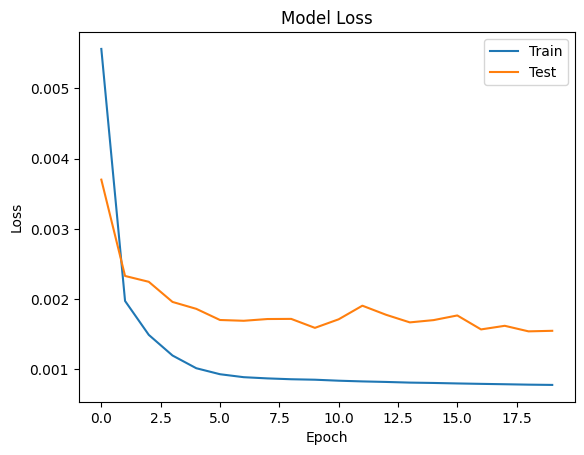

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test RMSE var1: 0.684
Test RMSE var2: 3.432


In [18]:
temp = LSTMDataPreparer(df, n_in=24, n_out=1)
temp.train_model()
temp.evaluate()
temp.model.save("lstm.h5")

In [19]:
from joblib import dump, load
dump(temp.scaler, 'minmax_scaler.joblib')

['minmax_scaler.joblib']